# **Enterprise Sales Analysis**

Objective: Gain industry insight by visualizing sales data.

 
Data being used is from the Japanese Government Statistics website.


### Data Details

*   Data Source：e-stat.go.jp
*   Format：JSON
*   Extracted Data: Economic Structure Survey




### Data Extraction

In [1]:
import requests
import pandas as pd

In [2]:
try:
  # Extract JSON file
  app_id = '1b32db0d63fefc9bc09c7074764b410f16efc222'
  url = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?appId=' + \
  app_id + '&lang=E&statsDataId=0003414037&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1'
  req = requests.get(url)
except requests.exceptions.TooManyRedirects:
  print("In order to not get stuck in a URL redirect loop, the request has been halted. Please check the URL.")
  raise SystemExit()
except requests.exceptions.RequestException as e:
  # Catch other errors
  raise SystemExit(e)

In [3]:
# Confirm extraction success
if req.status_code == 200:
  print("Data extraction successful")
else:
  print("Error Encountered: " + req.status_code)

Data extraction successful


In [4]:
req_dict = req.json()
# Check JSON levels
req_dict['GET_STATS_DATA']

{'PARAMETER': {'ANNOTATION_GET_FLG': 'Y',
  'CNT_GET_FLG': 'N',
  'DATA_FORMAT': 'J',
  'EXPLANATION_GET_FLG': 'Y',
  'LANG': 'E',
  'METAGET_FLG': 'Y',
  'SECTION_HEADER_FLG': 1,
  'START_POSITION': 1,
  'STATS_DATA_ID': '0003414037'},
 'RESULT': {'DATE': '2021-01-31T15:44:37.910+09:00',
  'ERROR_MSG': 'The process has been successfully completed.',
  'STATUS': 0},
 'STATISTICAL_DATA': {'CLASS_INF': {'CLASS_OBJ': [{'@id': 'tab',
     '@name': 'Tabulated variable',
     'CLASS': [{'@code': '01',
       '@level': '',
       '@name': 'Number of enterprises, etc.'},
      {'@code': '02',
       '@level': '',
       '@name': 'Sales (income)',
       '@unit': 'million yen'}]},
    {'@id': 'cat01',
     'CLASS': [{'@code': '00', '@level': '1', '@name': 'E--R Industries'},
      {'@code': '01',
       '@level': '2',
       '@name': 'E Manufacturing',
       '@parentCode': '00'},
      {'@code': '0101',
       '@level': '3',
       '@name': '09 Manufacture of food',
       '@parentCode': '01'}

In [5]:
extr = req_dict['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ'][1]

In [6]:
pd.json_normalize(extr['CLASS'])

,@code,@name,@level,@parentCode
0,00,E--R Industries,1,NaN
1,01,E Manufacturing,2,00
2,0101,09 Manufacture of food,3,01
3,010101,091 Livestock products,4,0101
4,010102,092 Seafood products,4,0101
...,...,...,...,...
564,140504,"929 Business services, n.e.c.",4,1405
565,1406,95 Miscellaneous services,3,14
566,140601,951 Meeting halls,4,1406
567,140602,952 Slaughterhouses,4,1406


API section is still under development. Upon completion, it will be connected to the preprocessing section.

### Preprocessing

In [7]:
import pandas as pd
import numpy as np

In [8]:
# Read dataset into Pandas dataframe
df = pd.read_csv("Industry_Data_2019.csv")
# Peek at dataset
df.head()

,Area classification Code,Area classification,Time Code,Time,"Industry of enterprise, etc. Code","Industry of enterprise, etc.",/Tabulated variable,"Number of enterprises, etc.",Sales (income)[million yen],"Number of enterprises, etc..1",Sales (income)[million yen].1,"Number of enterprises, etc..2",Sales (income)[million yen].2
0,0,Japan,2019000000,2019,0,E--R Industries,NaN,"1,333,501","1,520,656,648","1,204,653","1,328,807,082","128,848","191,849,566"
1,0,Japan,2019000000,2019,1,E Manufacturing,NaN,"204,017","413,224,430","202,019","412,385,485","1,998","838,945"
2,0,Japan,2019000000,2019,101,09 Manufacture of food,NaN,"20,670","35,748,641","20,087","35,405,024",583,"343,616"
3,0,Japan,2019000000,2019,10101,091 Livestock products,NaN,"1,913","9,991,250","1,828","9,764,837",85,"226,413"
4,0,Japan,2019000000,2019,10102,092 Seafood products,NaN,"4,422","4,664,091","4,341","4,643,805",81,"20,287"


In [9]:
#Investigate datatypes
print(df.isna().sum())
print(df.dtypes)

# Cast enteprise label section to string
df['Industry of enterprise, etc.'] = df['Industry of enterprise, etc.'].astype(str)

Area classification Code               0
Area classification                    0
Time Code                              0
Time                                   0
Industry of enterprise, etc. Code      0
Industry of enterprise, etc.           0
/Tabulated variable                  569
Number of enterprises, etc.            0
Sales (income)[million yen]            0
Number of enterprises, etc..1          0
Sales (income)[million yen].1          0
Number of enterprises, etc..2          0
Sales (income)[million yen].2          0
dtype: int64
Area classification Code               int64
Area classification                   object
Time Code                              int64
Time                                   int64
Industry of enterprise, etc. Code      int64
Industry of enterprise, etc.          object
/Tabulated variable                  float64
Number of enterprises, etc.           object
Sales (income)[million yen]           object
Number of enterprises, etc..1         object
Sale

In [10]:
# For now, I'm only interested in the following columns:
# Industry of enterprise, number of enterprises, and sales
# The other columns distinguish between companies and non-company corps
df = df[['Industry of enterprise, etc.', 'Number of enterprises, etc.', 'Sales (income)[million yen]']]
df.head()

,"Industry of enterprise, etc.","Number of enterprises, etc.",Sales (income)[million yen]
0,E--R Industries,"1,333,501","1,520,656,648"
1,E Manufacturing,"204,017","413,224,430"
2,09 Manufacture of food,"20,670","35,748,641"
3,091 Livestock products,"1,913","9,991,250"
4,092 Seafood products,"4,422","4,664,091"


In [11]:
# Note that the dataset has a top-level row we won't be using; this will be 
# removed, but the indexes have to change accordingly
df = df[1:]

# Rename columns for simplicity
df.columns = ["Enterprise", "Number of Businesses", "Sales"]
df.head()

,Enterprise,Number of Businesses,Sales
1,E Manufacturing,"204,017","413,224,430"
2,09 Manufacture of food,"20,670","35,748,641"
3,091 Livestock products,"1,913","9,991,250"
4,092 Seafood products,"4,422","4,664,091"
5,093 Canned and preserved fruit and vegetable p...,"1,433","856,417"


Note: Information is missing from dataset for 'Manufactured ice' on row 16 and 'Tobacco manufactures' on row 17. The number of businesses listed for tobacco manufactures is one, so Japan Tobacco (日本たばこ産業株式会社; JT), the only Japanese company with the vast majority of market share, has been selected for revenue imputation. According to JT's financial highlights fact sheet (https://www.jti.co.jp/investors/individual/finance/index.html), inside sales account for 611.5 billion yen, while outside sales account for 568.9 billion yen, for a total of 1,180.400 billion yen.

Because we know how much the aggregated total is for the sub-category 'Manufacture of beverages, tobacco, and feed,' we can infer the remaining amount for 'Manufactured ice' to be 1,753,438 million yen.


In [12]:
df[df['Sales'] == 'X']

,Enterprise,Number of Businesses,Sales
16,104 Manufactured ice,128,X
17,105 Tobacco manufactures,1,X


In [13]:
# Format sales and businesses columns so analysis can be performed
df['Sales'].replace(',','', regex=True, inplace=True)
df['Number of Businesses'].replace(',','', regex=True, inplace=True)

# See above for imputation strategy
df.at[16, 'Sales'] = '1753438'
df.at[17, 'Sales'] = '1180400'

# Cast the remaining column entries to int
df['Sales'] = df['Sales'].astype('int64')
df['Number of Businesses'] = df['Number of Businesses'].astype('int64')

Observe that the dataset has levels for industry and sub-industry. These will interfere with any sorting or aggregation that we would like to perform, so we will add them as a row label instead.

In [14]:
def CategoryLabel(dataset_df, mask, prefix_len, extract_col_name, category_col_name):
  # Prep dataframe to return; ensure original isn't affected by changes
  updated_df = dataset_df.copy(deep = True)
  category_df = updated_df.loc[mask]
  names = category_df[extract_col_name].unique()

  categories = []
  level_labels = []
  # Get names of categories
  for s in names:
    level_labels.append(s)
    #a = s.split(" ")
    # Remove prefix denoting level
    a = (''.join([i for i in s[prefix_len+1:]]))
    categories.append(a.lstrip(' '))

  indexes = []
  # Get indexes so appropriate rows can be given the category label
  index_start_points = [i-1 for i in list(category_df.index.values)]
  indexes = index_start_points[1:]
  indexes.append(len(updated_df)+1)

  # Create new dataframe column and populate row-by-row
  updated_df[category_col_name] = ""
  i_target = 0

  i_target = indexes.pop(0)
  industry = categories.pop(0)
  # Must have +1 or last row of array won't be reached
  for i in range(0, len(updated_df)+1):
    if i == i_target+1 and len(indexes) != 0:
      i_target = indexes.pop(0)
      industry = categories.pop(0)
    updated_df.at[i, category_col_name] = industry
    
  # Remove label rows
  updated_df = updated_df[~updated_df[extract_col_name].isin(level_labels)]
  updated_df.reset_index(inplace = True, drop = True)
  # Note: Behavior observed where rows are erroneously created during the loop
  # This row is designated as index 0. This may be Pandas-side behavior
  updated_df.drop(len(updated_df)-1, inplace = True)
  
  # Use the following statement to verify functionality.
  # Number of rows dropped should match number of categories
  #print('DEBUG: Category Rows: %d // Rows Removed: %d' % (len(names), len(dataset_df) - len(updated_df)))
  return updated_df

In [15]:
# For main industry notation

# Denote main section and subsections
temp_series = df['Enterprise'].str.split(' ', expand = True)[0]
# Remove alphabet marker that precedes industry name
mask = (temp_series.str.len() == 1)
# Call method to associate label with record
ind_labeled_df = CategoryLabel(df, mask, 1, "Enterprise", "Industry")
ind_labeled_df

,Enterprise,Number of Businesses,Sales,Industry
0,09 Manufacture of food,20670.0,35748641.0,Manufacturing
1,091 Livestock products,1913.0,9991250.0,Manufacturing
2,092 Seafood products,4422.0,4664091.0,Manufacturing
3,093 Canned and preserved fruit and vegetable p...,1433.0,856417.0,Manufacturing
4,094 Seasonings,1459.0,2822390.0,Manufacturing
...,...,...,...,...
549,"929 Business services, n.e.c.",17189.0,10685850.0,"Services, n.e.c."
550,95 Miscellaneous services,946.0,388067.0,"Services, n.e.c."
551,951 Meeting halls,744.0,219329.0,"Services, n.e.c."
552,952 Slaughterhouses,70.0,46919.0,"Services, n.e.c."


In [16]:
# For sub-industries

# Denote main section and subsections
temp_series = ind_labeled_df['Enterprise'].str.split(' ', expand = True)[0]
mask = (temp_series.str.len() == 2)

# Call method to associate label with record
labeled_df = CategoryLabel(ind_labeled_df, mask, 2, "Enterprise", "Sub-Industry")
labeled_df

,Enterprise,Number of Businesses,Sales,Industry,Sub-Industry
0,091 Livestock products,1913.0,9991250.0,Manufacturing,Manufacture of food
1,092 Seafood products,4422.0,4664091.0,Manufacturing,Manufacture of food
2,093 Canned and preserved fruit and vegetable p...,1433.0,856417.0,Manufacturing,Manufacture of food
3,094 Seasonings,1459.0,2822390.0,Manufacturing,Manufacture of food
4,095 Sugar processing,93.0,560548.0,Manufacturing,Manufacture of food
...,...,...,...,...,...
464,923 Guard services,3522.0,2487820.0,"Services, n.e.c.",Miscellaneous business services
465,"929 Business services, n.e.c.",17189.0,10685850.0,"Services, n.e.c.",Miscellaneous business services
466,951 Meeting halls,744.0,219329.0,"Services, n.e.c.",Miscellaneous services
467,952 Slaughterhouses,70.0,46919.0,"Services, n.e.c.",Miscellaneous services


In [17]:
# Define method to remove number denoting enterprise-level
def RemovePrefix(s):
    a = s.split(" ")
    return (''.join([i for i in s[4:]]))

labeled_df['Enterprise'] = labeled_df['Enterprise'].apply(RemovePrefix)

In [18]:
# Calculate average sales per enterprise

labeled_df['Average Sales per Business'] = labeled_df['Sales']/labeled_df['Number of Businesses']
labeled_df['Average Sales per Business'] = labeled_df['Average Sales per Business'].astype(np.int64)
labeled_df

,Enterprise,Number of Businesses,Sales,Industry,Sub-Industry,Average Sales per Business
0,Livestock products,1913.0,9991250.0,Manufacturing,Manufacture of food,5222
1,Seafood products,4422.0,4664091.0,Manufacturing,Manufacture of food,1054
2,Canned and preserved fruit and vegetable products,1433.0,856417.0,Manufacturing,Manufacture of food,597
3,Seasonings,1459.0,2822390.0,Manufacturing,Manufacture of food,1934
4,Sugar processing,93.0,560548.0,Manufacturing,Manufacture of food,6027
...,...,...,...,...,...,...
464,Guard services,3522.0,2487820.0,"Services, n.e.c.",Miscellaneous business services,706
465,"Business services, n.e.c.",17189.0,10685850.0,"Services, n.e.c.",Miscellaneous business services,621
466,Meeting halls,744.0,219329.0,"Services, n.e.c.",Miscellaneous services,294
467,Slaughterhouses,70.0,46919.0,"Services, n.e.c.",Miscellaneous services,670


### Data Aggregation


We will aggregate information in an attempt to answer the folliwing:


*   Which enterprise has the largest overall amount of sales?
*   Which industry is most efficient, in terms of sales per individual company?
*   Of the enterprises with the top sales, which has the highest market share for its industry?



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

#### Which enterprise has the largest overall amount of sales?

In [20]:
# Group by main industry and aggregate sales values by mean. Sort by sales
agg_df = labeled_df.groupby(['Industry']).mean().sort_values(by=['Sales'], ascending = False)
# Select the top 8
agg_df = agg_df.head(8)
# Create a graph legend for corresponding industries
industry_legend = list(agg_df.index.values)
agg_plot = agg_df.reset_index()

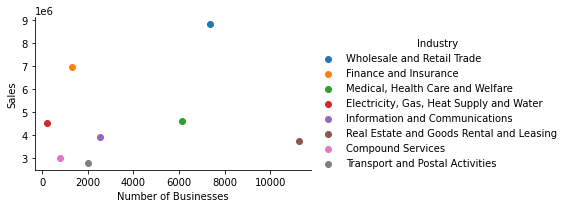

In [21]:
fg = sns.FacetGrid(data=agg_plot, hue='Industry', hue_order=industry_legend, aspect=1.61)
fg.map(plt.scatter, 'Number of Businesses', 'Sales').add_legend()

#### Which industry is most efficient, in terms of sales per individual company?

In [22]:
# Group by main industry and aggregate sales values by mean. Sort by average sales per business
agg_df = labeled_df.groupby(['Industry']).mean().sort_values(by=['Average Sales per Business'], ascending = False)
# Select top 8
agg_df = agg_df.head(8)
# Create graph legend
industry_legend = list(agg_df.index.values)
agg_plot = agg_df.reset_index()

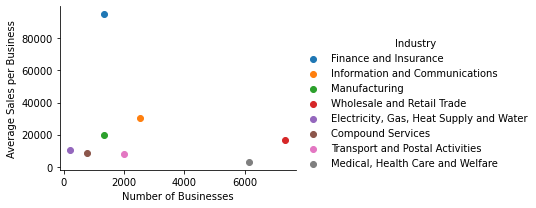

In [23]:
fg = sns.FacetGrid(data=agg_plot, hue='Industry', hue_order=industry_legend, aspect=1.61)
fg.map(plt.scatter, 'Number of Businesses', 'Average Sales per Business').add_legend()

#### Of the enterprises with the top sales, which has the highest market share for its industry?

In [24]:
# Get the greatest number of sales produced by an enterprise in each industry category
idx = labeled_df.groupby(['Industry'])['Sales'].transform(max) == labeled_df['Sales']
# Sort by sales
largest_sales = labeled_df[idx].sort_values(['Sales'], ascending = False)
largest_sales.reset_index(inplace = True, drop = True)

industry_sales = labeled_df.groupby(['Industry']).sum()
industry_sales = industry_sales['Sales']

In [25]:
chart_data = largest_sales.head(5)
stack_chart = []
# Create dictionary to convert to dataframe that contains information for graph
for i in range(0, len(chart_data)):
    industry = chart_data.loc[i, "Industry"]
    enterprise = chart_data.loc[i, "Enterprise"]
    enterprise_sales = chart_data.loc[i, "Sales"]

    # Calculate percentage of market share
    mkt_share = round((enterprise_sales / industry_sales[industry]),4)*100
    # Remaining market share, held by other enterprises
    remaining = 100 - mkt_share

    stack_chart.append(
        {
            'Industry': industry,
            'Enterprise': enterprise,
            'Sales': mkt_share,
            'Remaining Industry Sales': remaining
        }
    )
stack_df = pd.DataFrame(stack_chart)

In [26]:
stack_df

,Industry,Enterprise,Sales,Remaining Industry Sales
0,Manufacturing,"Motor vehicles, parts and accessories",17.36,82.64
1,"Medical, Health Care and Welfare",Social insurance organizations,56.21,43.79
2,Finance and Insurance,Life insurance institutions,39.27,60.73
3,Wholesale and Retail Trade,Food and beverages,6.63,93.37
4,Information and Communications,Computer programming and other software services,37.19,62.81


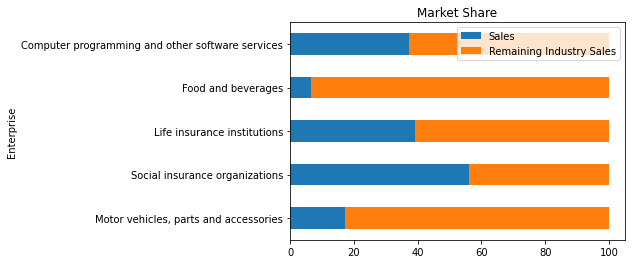

In [27]:
stack_df.plot(
    x = 'Enterprise',
    kind = 'barh',
    stacked = True,
    title = 'Market Share',
    mark_right = True
)